In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
import numpy as np
import cv2
import tarfile
from pathlib import Path
from tqdm import tqdm
import shutil
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers as tfl
from tensorflow.keras.layers import *
from tensorflow_addons.image import transform as H_transform
import matplotlib.pyplot as plt
import os, datetime

In [3]:
seed = 1

In [4]:
!pwd

/root/Internship-Valeo/Project


In [5]:
DATA_PATH = '/root/Internship-Valeo/Project/data'

In [6]:
from datasets import synthetic_dataset
from datasets.utils import pipeline
from datasets.utils.pipeline import parse_primitives
from datasets.utils import photometric_augmentation as photaug
from models.homographies import (sample_homography, compute_valid_mask,
                                            warp_points, filter_points, flat2mat, mat2flat)
from models.utils import box_nms

In [7]:
# read keypoints
def _read_points(filename):
    return np.load(filename).astype(np.float32)

In [8]:
model_config = {
            'data_format': 'channels_last',
            'grid_size': 8,
            'detection_threshold': 0.001,
            'descriptor_size': 256,
            'batch_size': 2,
            'epochs': 25,
            'learning_rate': 0.0001,
            'lambda_d': 0.05,
            'descriptor_size': 256,
            'positive_margin': 1.0,
            'negative_margin': 0.2,
            'lambda_loss': 10000,
            'nms': 4,
            'top_k': 0
    }

In [9]:
def vgg_block(inputs, filters, kernel_size, name, data_format, training=False,
              batch_normalization=True, kernel_reg=0., **params):
    x = tfl.Convolution2D(filters, kernel_size, kernel_initializer='he_uniform',
                       kernel_regularizer=tf.keras.regularizers.L2(kernel_reg),
                       data_format=data_format, **params)(inputs)
    if batch_normalization:
        x = tfl.BatchNormalization(
                    fused=True,
                    axis=1 if data_format == 'channels_first' else -1)(x)
    return x

In [10]:
def shared_encoder(model_config, shape = (240, 320,1)):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel
    pool_size=(2, 2)
    kernel = 3
    inputs = Input(shape)
    # Encoder
    conv1 = vgg_block(inputs, 64, (kernel, kernel), 'conv1_1', **params_conv)
    conv2 = vgg_block(conv1, 64, (kernel, kernel), 'conv1_2', **params_conv)
    pool1 = MaxPooling2D(pool_size, name="block1_pool")(conv2)

    conv3 = vgg_block(pool1, 64, (kernel, kernel), 'conv2_1', **params_conv)
    conv4 = vgg_block(conv3, 64, (kernel, kernel), 'conv2_2', **params_conv)
    pool2 = MaxPooling2D(pool_size, name="block2_pool")(conv4)

    conv5 = vgg_block(pool2, 128, (kernel, kernel), 'conv3_1', **params_conv)
    conv6 = vgg_block(conv5, 128, (kernel, kernel), 'conv3_2', **params_conv)
    pool3 = MaxPooling2D(pool_size, name="block3_pool")(conv6)

    conv7 = vgg_block(pool3, 128, (kernel, kernel), 'conv4_1', **params_conv)
    conv8 = vgg_block(conv7, 128, (kernel, kernel), 'conv4_2', **params_conv)
    return keras.models.Model(inputs = inputs, outputs = conv8, name = 'shared_encoder')

In [11]:
def detector_head(model_config, shape = (30, 40, 128)):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel

    inputs = Input(shape)
    x = vgg_block(inputs, 256, 3, 'conv1',
                      activation=tf.nn.relu, **params_conv)
    x = vgg_block(x, 1+pow(model_config['grid_size'], 2), 1, 'conv2',
                      activation=None, **params_conv)

    prob = tf.nn.softmax(x, axis=cindex)
    # Strip the extra “no interest point” dustbin
    prob = prob[:, :-1, :, :] if cfirst else prob[:, :, :, :-1]
    prob = tf.nn.depth_to_space(
              prob, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
    prob = tf.squeeze(prob, axis=cindex)
#     return {'logits': x, 'prob': prob}
    return keras.models.Model(inputs = inputs, outputs = {'logits': x, 'prob': prob}, name = 'detector_head')

In [12]:
def detector_loss(keypoint_map, logits, valid_mask=None):
    
    if model_config['data_format'] == 'channels_first':
        logits = tf.transpose(logits, [0, 2, 3, 1])
    # Convert the boolean labels to indices including the "no interest point" dustbin
    labels = keypoint_map#[..., tf.newaxis]  # for GPU
    labels = tf.cast(labels, tf.float32)
    labels = tf.nn.space_to_depth(labels, model_config['grid_size'])
    shape = tf.concat([tf.shape(labels)[:3], [1]], axis=0)
    labels = tf.concat([2*labels, tf.ones(shape)], 3)
    # Add a small random matrix to randomly break ties in argmax
    labels = tf.argmax(labels + tf.random.uniform(tf.shape(labels), 0, 0.1), axis=3)
    # Mask the pixels if bordering artifacts appear
    valid_mask = tf.ones_like(keypoint_map) if valid_mask is None else valid_mask
#     valid_mask = valid_mask[..., tf.newaxis]  # for GPU
    valid_mask = tf.cast(valid_mask, tf.float32)
    valid_mask = tf.nn.space_to_depth(valid_mask, model_config['grid_size'])
    valid_mask = tf.math.reduce_prod(valid_mask, axis=3)  # AND along the channel dim
    valid_mask = tf.cast(valid_mask, tf.int64)
#     labels = labels * valid_mask
#     loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    loss = tf.compat.v1.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits, weights=valid_mask)
    return tf.reduce_mean(loss)

In [13]:
def descriptor_head(shape, model_config):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
    
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel
    inputs = Input(shape)
    x = vgg_block(inputs, 256, 3, 'conv1',
                      activation=tf.nn.relu, **params_conv)
    x = vgg_block(x, model_config['descriptor_size'], 1, 'conv2',
                      activation=None, **params_conv)

    desc = tf.transpose(x, [0, 2, 3, 1]) if cfirst else x
    desc = tf.image.resize(
            desc, model_config['grid_size'] * tf.shape(desc)[1:3], method='bilinear')
    desc = tf.transpose(desc, [0, 3, 1, 2]) if cfirst else desc
    desc = tf.nn.l2_normalize(desc, cindex)

#     return {'descriptors_raw': x, 'descriptors': desc}
    return keras.models.Model(inputs = inputs, outputs = {'descriptors_raw': x, 'descriptors': desc}, name = 'descriptor_head')

In [14]:
def descriptor_loss(descriptors, warped_descriptors, homographies,
                    model_config = model_config, valid_mask=None):
    # Compute the position of the center pixel of every cell in the image
    (batch_size, Hc, Wc) = tf.unstack(tf.cast(tf.shape(descriptors)[:3], tf.int32))
    coord_cells = tf.stack(tf.meshgrid(
        tf.range(Hc), tf.range(Wc), indexing='ij'), axis=-1)
    coord_cells = coord_cells * model_config['grid_size'] + model_config['grid_size'] // 2  # (Hc, Wc, 2)
    # coord_cells is now a grid containing the coordinates of the Hc x Wc
    # center pixels of the 8x8 cells of the image

    # Compute the position of the warped center pixels
    warped_coord_cells = warp_points(tf.reshape(coord_cells, [-1, 2]), homographies)
    # warped_coord_cells is now a list of the warped coordinates of all the center
    # pixels of the 8x8 cells of the image, shape (N, Hc x Wc, 2)

    # Compute the pairwise distances and filter the ones less than a threshold
    # The distance is just the pairwise norm of the difference of the two grids
    # Using shape broadcasting, cell_distances has shape (N, Hc, Wc, Hc, Wc)
    coord_cells = tf.cast(tf.reshape(coord_cells, [1, 1, 1, Hc, Wc, 2]), tf.float32)
    warped_coord_cells = tf.reshape(warped_coord_cells,
                                    [batch_size, Hc, Wc, 1, 1, 2])
    cell_distances = tf.norm(coord_cells - warped_coord_cells, axis=-1)
    s = tf.cast(tf.less_equal(cell_distances, model_config['grid_size'] - 0.5), tf.float32)
    # s[id_batch, h, w, h', w'] == 1 if the point of coordinates (h, w) warped by the
    # homography is at a distance from (h', w') less than config['grid_size']
    # and 0 otherwise

    # Normalize the descriptors and
    # compute the pairwise dot product between descriptors: d^t * d'
    descriptors = tf.reshape(descriptors, [batch_size, Hc, Wc, 1, 1, -1])
    descriptors = tf.nn.l2_normalize(descriptors, -1)
    warped_descriptors = tf.reshape(warped_descriptors,
                                    [batch_size, 1, 1, Hc, Wc, -1])
    warped_descriptors = tf.nn.l2_normalize(warped_descriptors, -1)
    dot_product_desc = tf.reduce_sum(descriptors * warped_descriptors, -1)
    dot_product_desc = tf.nn.relu(dot_product_desc)
    dot_product_desc = tf.reshape(tf.nn.l2_normalize(
        tf.reshape(dot_product_desc, [batch_size, Hc, Wc, Hc * Wc]),
        3), [batch_size, Hc, Wc, Hc, Wc])
    dot_product_desc = tf.reshape(tf.nn.l2_normalize(
        tf.reshape(dot_product_desc, [batch_size, Hc * Wc, Hc, Wc]),
        1), [batch_size, Hc, Wc, Hc, Wc])
    # dot_product_desc[id_batch, h, w, h', w'] is the dot product between the
    # descriptor at position (h, w) in the original descriptors map and the
    # descriptor at position (h', w') in the warped image

    # Compute the loss
    positive_dist = tf.maximum(0., model_config['positive_margin'] - dot_product_desc)
    negative_dist = tf.maximum(0., dot_product_desc - model_config['negative_margin'])
    loss = model_config['lambda_d'] * s * positive_dist + (1 - s) * negative_dist

    # Mask the pixels if bordering artifacts appear
    valid_mask = tf.ones([batch_size,
                          Hc * model_config['grid_size'],
                          Wc * model_config['grid_size']], tf.float32)\
        if valid_mask is None else valid_mask
#     valid_mask = tf.cast(valid_mask[..., tf.newaxis], tf.float32)  # for GPU
    valid_mask = tf.nn.space_to_depth(valid_mask, model_config['grid_size'])
    valid_mask = tf.reduce_prod(valid_mask, axis=3)  # AND along the channel dim
    valid_mask = tf.reshape(valid_mask, [batch_size, 1, 1, Hc, Wc])

    normalization = tf.reduce_sum(valid_mask) * tf.cast(Hc * Wc, tf.float32)
    # Summaries for debugging
    # tf.summary.scalar('nb_positive', tf.reduce_sum(valid_mask * s) / normalization)
    # tf.summary.scalar('nb_negative', tf.reduce_sum(valid_mask * (1 - s)) / normalization)
    tf.summary.scalar('positive_dist', tf.reduce_sum(valid_mask * model_config['lambda_d'] *
                                                     s * positive_dist) / normalization)
    tf.summary.scalar('negative_dist', tf.reduce_sum(valid_mask * (1 - s) *
                                                     negative_dist) / normalization)
    loss = tf.reduce_sum(valid_mask * loss) / normalization
    return loss

In [15]:
class HomographyLayer(Layer):
    def call(self, inputs):
        return inputs

def HomographyModel(shape = (8,)):
    x = Input(shape)
    output = HomographyLayer(name="homography_layer", trainable=False)(x)
    return keras.models.Model(inputs = x, outputs = output)

class DescriptorLossLayer(Layer):
    def __init__(self, name='descriptor_loss_layer', trainable=False):
        super(DescriptorLossLayer, self).__init__(name=name)
        self.loss_fn = descriptor_loss
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = model_config['lambda_loss']*self.loss_fn(descriptors = inputs[0], 
                                                        warped_descriptors = inputs[1], 
                                                        homographies = inputs[2], 
                                                        valid_mask = inputs[3])
        self.add_loss(loss)
        return tf.reshape(loss, (1,))
#     def compute_output_shape(self, input_shape):
#         return [1]
    
class DetectorLossLayer(Layer):
    def __init__(self, name='detector_loss_layer', trainable=False):
        super(DetectorLossLayer, self).__init__(name=name)
        self.loss_fn = detector_loss
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(keypoint_map = inputs[0], logits = inputs[1])
        self.add_loss(loss)
        return loss
#     def compute_output_shape(self, input_shape):
#         return [1]

class WarpedDetectorLossLayer(Layer):
    def __init__(self, name='warped_detector_loss_layer', trainable=False):
        super(WarpedDetectorLossLayer, self).__init__(name=name)
        self.loss_fn = detector_loss
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(keypoint_map = inputs[0], logits = inputs[1], 
                            valid_mask = inputs[2])
        self.add_loss(loss)
        return loss
#     def compute_output_shape(self, input_shape):
#         return [1]
    
def net():
    
    images_input = Input(shape = (240, 320,1), name = 'images_input')
    points_maps_input = Input(shape = (240, 320, 1), name = 'points_maps_input') 
    homography_list_input = Input(shape = (8,), name = 'homography_list_input') 
    warped_images_input = Input(shape = (240, 320, 1), name = 'warped_images_input')

    valid_masks_input = Input(shape = (240, 320,1), name = 'valid_masks_input')
    warped_points_maps_input = Input(shape = (240, 320, 1), name = 'warped_points_maps_input')
    
    homography_model = HomographyModel()
    homography = homography_model(homography_list_input)
    
    encoder = shared_encoder(model_config = model_config)
    encoder_output = encoder(images_input)
    warped_encoder_output = encoder(warped_images_input)
    
    detector = detector_head(model_config = model_config)
    detector_output = detector(encoder_output)
    warped_detector_output = detector(warped_encoder_output)
    
    descriptor = descriptor_head(shape = (30, 40, 128), model_config=model_config)
    descriptor_output = descriptor(encoder_output)
    warped_descriptor_output = descriptor(warped_encoder_output)

    detector_loss_layer = DetectorLossLayer()([points_maps_input, detector_output['logits']])
    warped_detector_loss_layer = WarpedDetectorLossLayer()([warped_points_maps_input, 
                                                warped_detector_output['logits'], 
                                                      valid_masks_input])
    
    descriptor_loss_layer = DescriptorLossLayer()([descriptor_output['descriptors_raw'], 
                                                   warped_descriptor_output['descriptors_raw'], 
                                          homography, valid_masks_input])
    
    model = keras.models.Model(inputs = [images_input, homography_list_input, warped_images_input, 
                                         valid_masks_input, points_maps_input, warped_points_maps_input],
                                        
                               outputs = [detector_loss_layer, warped_detector_loss_layer, 
                                          descriptor_loss_layer])
    return model

In [16]:
model = net()

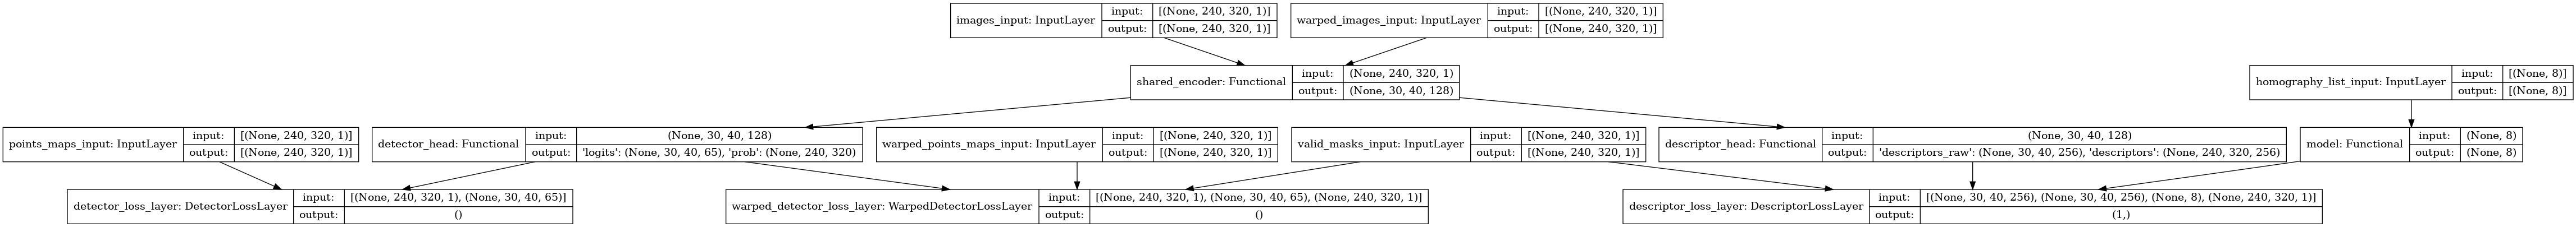

In [17]:
# model.summary()
keras.utils.plot_model(model, to_file="model.png", show_shapes=True, show_dtype=False, show_layer_names=True,
    rankdir="TB", expand_nested=False, dpi=96)

In [18]:
def model_metrics(y_true, y_pred):
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel

    y_pred = tf.nn.softmax(y_pred, axis=cindex)
    y_pred = tf.argmax(y_pred, axis =cindex)
  
    y_pred = tf.one_hot(y_pred, depth = 1+pow(model_config['grid_size'], 2))
    y_true = tf.nn.space_to_depth(y_true, model_config['grid_size'])
    y_true = tf.cast(y_true, tf.float32)
    # Strip the extra “no interest point” dustbin
    y_pred = y_pred[:, :-1, :, :] if cfirst else y_pred[:, :, :, :-1]
   
    precision = tf.math.reduce_sum(y_pred * y_true) /tf.math.reduce_sum(y_pred)
    recall = tf.math.reduce_sum(y_pred * y_true) / tf.math.reduce_sum(y_true)
#     return {'precision': precision, 'recall': recall}
    return precision

In [19]:
model.load_weights('/root/Internship-Valeo/Project/results/checkpoint-superpoint-coco-14022022-latest')

In [20]:
# Make changes here for illumination vs viewpoint

config = {
    'data':{
        'name': 'patches_dataset',
        'dataset': 'hpatches',  # 'coco' 'hpatches'
        'alteration': 'v',  # 'all' 'i' 'v'
        'preprocessing':{'resize': [240, 320]},  # False for coco
        'truncate': False,
    },
    'augmentation':{
        'homographic':{
            'valid_border_margin':0
        },
    },
    'nms':8,
    'top_k':1000,
    'detection_threshold':.001,
}

In [21]:
dataset_folder = 'HPatches'
base_path = Path(DATA_PATH, dataset_folder)
folder_paths = [x for x in base_path.iterdir() if x.is_dir()]
image_paths = []
warped_image_paths = []
homographies = []
for path in folder_paths:
    if config['data']['alteration'] == 'i' and path.stem[0] != 'i':
        continue
    if config['data']['alteration'] == 'v' and path.stem[0] != 'v':
        continue
    num_images = 1 if config['data']['dataset'] == 'coco' else 5
    file_ext = '.ppm' if config['data']['dataset'] == 'hpatches' else '.jpg'
    for i in range(2, 2 + num_images):
        image_paths.append(str(Path(path, "1" + file_ext)))
        warped_image_paths.append(str(Path(path, str(i) + file_ext)))
        homographies.append(np.loadtxt(str(Path(path, "H_1_" + str(i)))))
if config['data']['truncate']:
    image_paths = image_paths[:config['truncate']]
    warped_image_paths = warped_image_paths[:config['truncate']]
    homographies = homographies[:config['truncate']]
files = {'image_paths': image_paths,
                 'warped_image_paths': warped_image_paths,
                 'homography': homographies}

In [22]:
def adapt_homography_to_preprocessing(homography, image_shape, warped_image_shape):
    H = tf.cast(homography, tf.float32)
    source_size = tf.cast(image_shape, tf.float32)
    source_warped_size = tf.cast(warped_image_shape, tf.float32)
    target_size = tf.cast(tf.convert_to_tensor(config['data']['preprocessing']['resize']),
                                  tf.float32)

    # Compute the scaling ratio due to the resizing for both images
    s = tf.reduce_max(tf.divide(target_size, source_size))
    up_scale = tf.linalg.diag(tf.stack([1. / s, 1. / s, tf.constant(1.)]))
    warped_s = tf.reduce_max(tf.divide(target_size, source_warped_size))
    down_scale = tf.linalg.diag(tf.stack([warped_s, warped_s, tf.constant(1.)]))

    # Compute the translation due to the crop for both images
    pad_y = tf.cast(((source_size[0] * s - target_size[0]) / tf.constant(2.0)), tf.int32)
    pad_x = tf.cast(((source_size[1] * s - target_size[1]) / tf.constant(2.0)), tf.int32)
    translation = tf.stack([tf.constant(1), tf.constant(0), pad_x, 
                                    tf.constant(0), tf.constant(1), pad_y,
                                    tf.constant(0),tf.constant(0), tf.constant(1)])
    translation = tf.cast(tf.reshape(translation, [3,3]), tf.float32)
    pad_y = tf.cast(((source_warped_size[0] * warped_s - target_size[0])
                                 / tf.constant(2.0)), tf.int32)
    pad_x = tf.cast(((source_warped_size[1] * warped_s - target_size[1])
                                 / tf.constant(2.0)), tf.int32)
    warped_translation = tf.stack([tf.constant(1), tf.constant(0), -pad_x, 
                                           tf.constant(0), tf.constant(1), -pad_y,
                                           tf.constant(0),tf.constant(0), tf.constant(1)])
    warped_translation = tf.cast(tf.reshape(warped_translation, [3,3]), tf.float32)
    H = warped_translation @ down_scale @ H @ up_scale @ translation
    return H

In [23]:
class DataGen(keras.utils.Sequence):
    def __init__(self, image_path, warped_image_path, homography,                  
                 image_size_x = 320, image_size_y = 240, batch_size = 2):
        
        self.__image_path = image_path
        self.__homography = homography
        self.__warped_image_path = warped_image_path
        self.__image_size_x = image_size_x
        self.__image_size_y = image_size_y
        self.__batch_size = batch_size
        self.on_epoch_end()
        
    def __getitem__(self, index):
        images = []
        homography_list = []
        warped_images = []
        valid_masks = []
        
        if (index + 1)*self.__batch_size > len(self.__image_path):
            self.__batch_size = len(self.__image_path) - index * self.__batch_size
            
        batch_img_files = self.__image_path[index * self.__batch_size:(index + 1) * self.__batch_size]
        batch_warped_img_files = self.__warped_image_path[
            index * self.__batch_size:(index + 1) * self.__batch_size]
        batch_homography = self.__homography[index * self.__batch_size:(index + 1) * self.__batch_size]
        for img_file, warped_img_file, homography, itr in zip(
            batch_img_files, batch_warped_img_files, batch_homography, range(self.__batch_size)):
            
            image = cv2.imread(img_file, 0)
            source_image_shape = image.shape
            image = cv2.resize(image , (self.__image_size_x , self.__image_size_y))
            image = np.expand_dims(image, axis = 2)
            image_shape = tf.shape(image)[:2]    
            # read warped image

            warped_image = cv2.imread(warped_img_file, 0)
            source_warped_image_shape = warped_image.shape
            warped_image = cv2.resize(warped_image , (self.__image_size_x , self.__image_size_y))
            warped_image = np.expand_dims(warped_image, axis = 2)
            
            homography = adapt_homography_to_preprocessing(homography, source_image_shape, 
                                                           source_warped_image_shape)
            
            homography = mat2flat(homography)
            homography = tf.squeeze(homography)
            homography_list.append(homography)
            # compute valid mask
            valid_mask = compute_valid_mask(image_shape, homography,
                                         config['augmentation']['homographic']['valid_border_margin'])
            valid_masks.append(valid_mask)
            warped_image = warped_image / 255.0
            warped_images.append(warped_image) 
            image = image / 255.0
            images.append(image)   
              
        images = np.array(images)
        warped_images = np.array(warped_images)
        homography_list = np.array(homography_list)
        valid_masks = np.array(valid_masks)
        return [images, homography_list, warped_images, valid_masks]

           
    def __len__(self):
        return int(np.ceil(len(self.__image_path) / float(self.__batch_size)))
    
    def on_epoch_end(self):
        pass

In [24]:
image_path = files['image_paths']
warped_image_path = files['warped_image_paths']
homography = files['homography']
test_set = DataGen(image_path, warped_image_path, homography, batch_size = 1)

In [25]:
x = test_set.__getitem__(6)

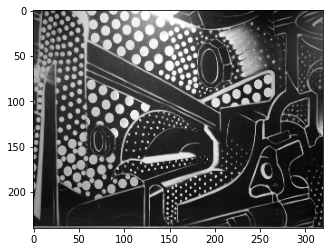

In [26]:
plt.imshow(x[0][0],cmap = 'gray')

In [27]:
from keras.models import Model

model = model # include here your original model

In [28]:
model.input

[<KerasTensor: shape=(None, 240, 320, 1) dtype=float32 (created by layer 'images_input')>,
 <KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'homography_list_input')>,
 <KerasTensor: shape=(None, 240, 320, 1) dtype=float32 (created by layer 'warped_images_input')>,
 <KerasTensor: shape=(None, 240, 320, 1) dtype=float32 (created by layer 'valid_masks_input')>,
 <KerasTensor: shape=(None, 240, 320, 1) dtype=float32 (created by layer 'points_maps_input')>,
 <KerasTensor: shape=(None, 240, 320, 1) dtype=float32 (created by layer 'warped_points_maps_input')>]

In [29]:
descriptor_model = Model(inputs=[model.input[0], model.input[1], model.input[2], model.input[3]],
                         outputs=model.get_layer('descriptor_loss_layer').input)

In [30]:
model.get_layer('descriptor_loss_layer').input

[<KerasTensor: shape=(None, 30, 40, 256) dtype=float32 (created by layer 'descriptor_head')>,
 <KerasTensor: shape=(None, 30, 40, 256) dtype=float32 (created by layer 'descriptor_head')>,
 <KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'model')>,
 <KerasTensor: shape=(None, 240, 320, 1) dtype=float32 (created by layer 'valid_masks_input')>]

In [31]:
detector_model = Model(inputs=[model.input[0], model.input[1], model.input[2], model.input[3]],
                         outputs=[model.get_layer('detector_loss_layer').input[1], 
                                  model.get_layer('warped_detector_loss_layer').input[1]])

In [32]:
model.get_layer('detector_head').output

{'logits': <KerasTensor: shape=(None, 30, 40, 65) dtype=float32 (created by layer 'batch_normalization_9')>,
 'prob': <KerasTensor: shape=(None, 240, 320) dtype=float32 (created by layer 'tf.compat.v1.squeeze')>}

In [33]:
model.get_layer('detector_loss_layer').input

[<KerasTensor: shape=(None, 240, 320, 1) dtype=float32 (created by layer 'points_maps_input')>,
 <KerasTensor: shape=(None, 30, 40, 65) dtype=float32 (created by layer 'detector_head')>]

In [34]:
model.get_layer('warped_detector_loss_layer').input

[<KerasTensor: shape=(None, 240, 320, 1) dtype=float32 (created by layer 'warped_points_maps_input')>,
 <KerasTensor: shape=(None, 30, 40, 65) dtype=float32 (created by layer 'detector_head')>,
 <KerasTensor: shape=(None, 240, 320, 1) dtype=float32 (created by layer 'valid_masks_input')>]

In [35]:
# Make changes here for illumination vs viewpoint

# output_dir = '/root/Internship-Valeo/Project/exports/superpoint_hpatches-i'
output_dir = '/root/Internship-Valeo/Project/exports/superpoint_hpatches-v'

In [36]:
for i in range(len(files['image_paths'])):
    filename = str(i)
    filepath = Path(output_dir, '{}.npz'.format(filename))
    
    x = test_set.__getitem__(i)
    
    descriptor_output = descriptor_model.predict(x)    
    
    y = descriptor_output[0]
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel

    desc1 = tf.transpose(y, [0, 2, 3, 1]) if cfirst else y
    desc1 = tf.image.resize(
            desc1, model_config['grid_size'] * tf.shape(desc1)[1:3], method='bilinear')
    desc1 = tf.transpose(desc1, [0, 3, 1, 2]) if cfirst else desc1
    desc1 = tf.nn.l2_normalize(desc1, cindex)
    
    
    y = descriptor_output[1]
    desc2 = tf.transpose(y, [0, 2, 3, 1]) if cfirst else y
    desc2 = tf.image.resize(
            desc2, model_config['grid_size'] * tf.shape(desc2)[1:3], method='bilinear')
    desc2 = tf.transpose(desc2, [0, 3, 1, 2]) if cfirst else desc2
    desc2 = tf.nn.l2_normalize(desc2, cindex)
    
    
    detector_output = detector_model.predict(x)
    
    
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel
    
    prob1 = tf.nn.softmax(detector_output[0], axis=cindex)
    # Strip the extra “no interest point” dustbin
    prob1 = prob1[:, :-1, :, :] if cfirst else prob1[:, :, :, :-1]
    prob1 = tf.nn.depth_to_space(
              prob1, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
    prob1 = tf.squeeze(prob1, axis=cindex)
    
    
    prob1 = tf.map_fn(lambda p: box_nms(
                p, config['nms'], keep_top_k=config['top_k']), prob1)
    
    prob2 = tf.nn.softmax(detector_output[1], axis=cindex)
    # Strip the extra “no interest point” dustbin
    prob2 = prob2[:, :-1, :, :] if cfirst else prob2[:, :, :, :-1]
    prob2 = tf.nn.depth_to_space(
              prob2, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
    prob2 = tf.squeeze(prob2, axis=cindex)
    prob2 = tf.map_fn(lambda p: box_nms(
                p, config['nms'], keep_top_k=config['top_k']), prob2)
    
    
    homography = tf.reshape(x[1][0], (1,8))
    homography = flat2mat(homography)
    pred = {'image': x[0][0],
            'warped_image': x[2][0],
            'prob': prob1[0],
            'warped_prob': prob2[0],
            'desc': desc1[0],
            'warped_desc': desc2[0],
            'homography': homography[0]}
    
    
    np.savez_compressed(filepath, **pred)